In [13]:
# 方程式を定義
# グローバル変数に、a,bが必要
import numpy as np
import math
import functools
from scipy import integrate

def func_r(q, b):
    value = q / (1 - b + b * q) / (1 - b + b * q)
    return value

def func_f_integrand(z, m, q, a, b):
    return math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a * func_r(q, b)) * z))

def func_f(m, q, a, b):
    func  = functools.partial(func_f_integrand, m=m, q=q, a=a, b=b)
#     print(integrate.quad(func, -100.0, 100.0)[1])
    return m - (1 / math.sqrt(2 * np.pi)) * integrate.quad(func, -10.0, 10.0)[0]


def func_g_integrand(z, m, q, a, b):
    return math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a * func_r(q, b)) * z)) ** 2

def func_g(m, q, a, b):
    func  = functools.partial(func_g_integrand, m=m, q=q, a=a, b=b)
#     print(integrate.quad(func, -100.0, 100.0)[1])
    return q - (1 / math.sqrt(2 * np.pi)) * integrate.quad(func, -10.0, 10.0)[0]


def plot_f_and_g(plot_num, zlim, args, a, b):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d', zlim=(-1.0, 1.0))
    ax.set_title("f(m,q) & g(m,q)", size = 20)

    ax.set_xlabel("m", size = 20)
    ax.set_ylabel("q", size = 20)
    ax.set_zlabel("", size = 20)

    x = np.linspace(args["m_min"], args["m_max"], plot_num)
    y = np.linspace(args["q_min"], args["q_max"], plot_num)

    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    
    F = np.ndarray([])
    G = np.ndarray([])
    for i in range(len(Y)-1):
        F = np.append(F, func_f(X[i], Y[i], a, b))
        G = np.append(G, func_g(X[i], Y[i], a, b))

    ax.scatter(X, Y, F, color = "red", label='f (m,q)')
    ax.scatter(X, Y, G, color = "green", label='g (m,q)')

    # これ呼ばないとラベルでない
    plt.legend()
    plt.show()
    

def a(z):
    return math.exp(-z**2/2)

result = integrate.quad(a, -10.0, 10.0)[0] / math.sqrt(2*3.14)
print(result)

1.0002535751093533


In [14]:
import numpy as np
import csv

# 解を見つけるためのクラス
class Solver:
    
    def __init__(self, a_mesh_num, T_mesh_num, mq_mesh_num, delta, func_1, func_2, debug):
        self.a_mesh_num = a_mesh_num
        self.T_mesh_num = T_mesh_num
        self.mq_mesh_num = mq_mesh_num
        self.delta = delta
        self.func_1 = func_1
        self.func_2 = func_2
        self.debug = debug
        
    def set_args(self, args):
        self.a_min = args["a_min"]
        self.a_max = args["a_max"]
        self.T_min = args["T_min"]
        self.T_max = args["T_max"]
        self.m_min = args["m_min"]
        self.m_max = args["m_max"]
        self.q_min = args["q_min"]
        self.q_max = args["q_max"]
        
        
    def solve(self):
        A = np.linspace(self.a_min, self.a_max, self.a_mesh_num)
        T = np.linspace(self.T_min, self.T_max, self.T_mesh_num)
        a_arr, t_arr = np.meshgrid(A, T)
        self.a_arr = a_arr.flatten()
        self.T_arr = t_arr.flatten()
        
        M = np.linspace(self.m_min, self.m_max, self.mq_mesh_num)
        Q = np.linspace(self.q_min, self.q_max, self.mq_mesh_num)
        m, q = np.meshgrid(M, Q)
        m = m.flatten()
        q = q.flatten()
        
        answer_m = []
        answer_q = []
        for i in range(len(self.a_arr)):
            m_i = []
            q_i = []

            a = self.a_arr[i]
            # βに変換しておく
            b = 1/self.T_arr[i]

            # ③,④
            for j in range(len(m)):
                if m[j] < 0.05 and q[j] < 0.05:
                    continue
                
                f = self.func_1(m[j], q[j], a, b)
                g = self.func_2(m[j], q[j], a, b)
#                 print("{0},{1},{2},{3},{4},{5}".format(a, self.T_arr[i], m[j], q[j], f, g))
                if abs(f) < self.delta and abs(g) < self.delta:
                        m_i.append(m[j])
                        q_i.append(q[j])
                
            answer_m_i = 0
            answer_q_i = 0
            for j in range(len(m_i)):
                if m_i[j] < 0:
                    continue
                answer_m_i = m_i[j]
                answer_q_i = q_i[j]
                
            if self.debug:
                print("a={0}, T={1}  =>  m={2}, q={3}".format(self.a_arr[i], self.T_arr[i], answer_m_i, answer_q_i))
            if self.debug:
                print("↓mの候補↓")
                print(m_i)
                print("↓qの候補↓")
                print(q_i)
                print("\n\n")

            answer_m.append(answer_m_i)
            answer_q.append(answer_q_i)
            
        self.m_answer_arr = answer_m
        self.q_answer_arr = answer_q
        
        
    def to_csv(self, filename):
        f = open(filename, "w")
        writer = csv.writer(f)
        for i in range(len(self.a_arr)):
            tmp = [
                self.a_arr[i], 
                self.T_arr[i], 
                self.m_answer_arr[i], 
                self.q_answer_arr[i],
            ]
            writer.writerow(tmp)
        f.close()

In [25]:
# solver = Solver(30, 30, 50, pow(10, -2), func_f, func_g, 1)

# solve_args = {
#     "a_min": 0,
#     "a_max": 0.3,
#     "T_min": 0.31,
#     "T_max": 1.31,
#     "m_min": -1,
#     "m_max": 1,
#     "q_min": 0,
#     "q_max": 1,
# }

# solver.set_args(solve_args)
# solver.solve()
# solver.to_csv("result0207.csv")

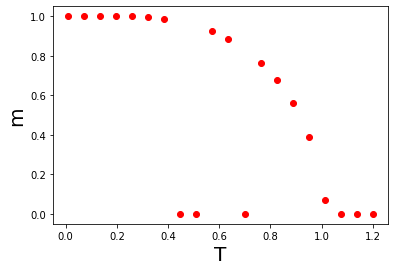

In [52]:
# α=0で検証
def func_f_2(m, q, a, b):
    return m - np.tanh(b * m)

def func_g_2(m, q, a, b):
    return q - np.tanh(b * m) ** 2


solver = Solver(1, 20, 500, pow(10, -3), func_f_2, func_g_2, 0)
solve_args = {
    "a_min": 0.0,
    "a_max": 0.0,
    "T_min": 0.01,
    "T_max": 1.2,
    "m_min": -1,
    "m_max": 1,
    "q_min": 0,
    "q_max": 1,
}

solver.set_args(solve_args)
solver.solve()
solver.to_csv("a_0_strict.csv")


result_arr = np.loadtxt("./a_0_strict.csv", delimiter=",")

result_a = result_arr[:, 0]
result_t = result_arr[:, 1]
result_m = result_arr[:, 2]
result_q = result_arr[:, 3]

fig = plt.figure()
ax_3 = fig.add_subplot(111)

ax_3.set_xlabel("T", size = 20)
ax_3.set_ylabel("m", size = 20)

ax_3.scatter(result_t, result_m, color="red")

plt.show()

# solver = Solver(1, 5, 50, pow(10, -4), func_f, func_g, 0)
# solver.set_args(solve_args)
# solver.solve()
# solver.to_csv("result2.csv")

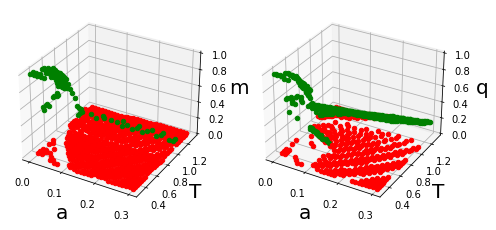

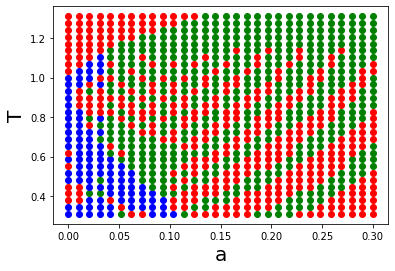

In [13]:
def plot_scatter(_ax, result_a_1, result_t_1, result_z_1, debug=False):
    for i in range(len(result_a_1)):
        if debug:
            print(result_a_1[i], result_t_1[i], result_z_1[i])
        _ax.scatter(result_a_1[i], result_t_1[i], result_z_1[i], color = "red" if result_z_1[i]<0.1 else "green")


# csv 読み出し
import matplotlib.pyplot as plt
result_arr = np.loadtxt("./result0207.csv", delimiter=",")

result_a = result_arr[:, 0]
result_t = result_arr[:, 1]
result_m = result_arr[:, 2]
result_q = result_arr[:, 3]

# プロット
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(121, projection='3d', zlim=(0, 1.0))

ax.set_xlabel("a", size = 20)
ax.set_ylabel("T", size = 20)
ax.set_zlabel("m", size = 20)

plot_scatter(ax, result_a, result_t, result_m)

# csv 読み出し
ax_2 = fig.add_subplot(122, projection='3d', zlim=(0, 1.0))

ax_2.set_xlabel("a", size = 20)
ax_2.set_ylabel("T", size = 20)
ax_2.set_zlabel("q", size = 20)

plot_scatter(ax_2, result_a, result_t, result_q)



fig = plt.figure()
ax_3 = fig.add_subplot(111)

ax_3.set_xlabel("a", size = 20)
ax_3.set_ylabel("T", size = 20)

for i in range(len(result_a)):
    color = "red" 
    if result_m[i] > 0.05 and result_q[i] > 0.05:
        color = "blue"
    elif result_q[i] > 0.05:
        color = "green"
    ax_3.scatter(result_a[i], result_t[i], color=color)


plt.show()

In [23]:
solver = Solver(1, 40, 25, pow(10, -2), func_f, func_g, 0)

solve_args = {
    "a_min": 0,
    "a_max": 0.3,
    "T_min": 0.01,
    "T_max": 1.31,
    "m_min": -1,
    "m_max": 1,
    "q_min": 0,
    "q_max": 1,
}

solver.set_args(solve_args)
solver.solve()
solver.to_csv("a_0_by_mesh_method.csv")

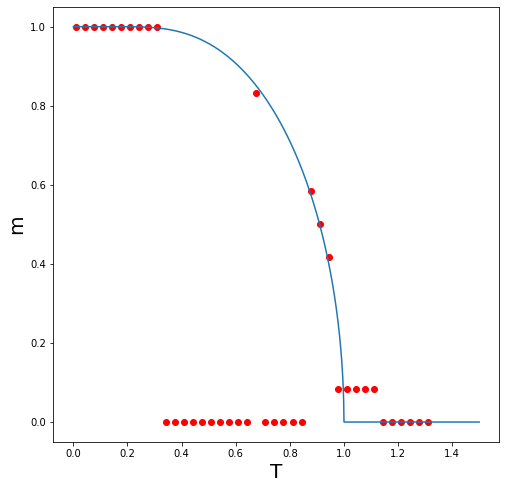

In [24]:
#  α=0のときの T vs mのグラフ

import matplotlib.pyplot as plt
import numpy as np

# グラフ設定
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)

ax.set_xlabel("T", size = 20)
ax.set_ylabel("m", size = 20)


# ニュートン法で解いたもの
newton_method_solve = np.loadtxt("./a_0_newton.csv")

newton_method_t = newton_method_solve[:, 0]
newton_method_m = newton_method_solve[:, 1]

ax.plot(newton_method_t, newton_method_m)


# 本来の積分ありの方程式を解いたもの
original_solve = np.loadtxt("./a_0_by_mesh_method.csv", delimiter=",")
original_a = original_solve[:, 0]
original_t = original_solve[:, 1]
original_m = original_solve[:, 2]

for i in range(len(original_m)):
    if original_a[i] == 0.0:
        ax.scatter(original_t[i], original_m[i], color = "red")